In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# надо поместить исходные файлы
# с данными в папку data

# тк данных очень много
# возьмем 2млн записей
train =  pd.read_csv(
    filepath_or_buffer='./data/train.csv',
    index_col=['row_id'],
    nrows=2_000_000,
)
lectures = pd.read_csv('./data/lectures.csv')
questions = pd.read_csv('./data/questions.csv')

In [3]:
# сохраняем исходные данные не тронутыми 
train_df = train.copy()
lectures_df = lectures.copy()
questions_df = questions.copy()

### Обработка пропусков и изменение типов

In [4]:
display(train_df.info());
display(train_df.isna().sum());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 152.6+ MB


None

timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       46676
prior_question_had_explanation     7693
dtype: int64

In [5]:
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(-1)
train_df['prior_question_had_explanation']  = train_df['prior_question_had_explanation'].astype(int)

In [6]:
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].fillna(-1)

In [7]:
display(train_df.info())
display(train_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  int32  
dtypes: float64(1), int32(1), int64(7)
memory usage: 145.0 MB


None

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

### EDA

In [8]:
# смерджим lectures и questions с исходным train_df

# переименуем колонки для избежания конфликта имен
# и для удобства чтения
lectures_df = lectures_df.rename(
    columns={
        'part': 'lecture_part',
        'tag': 'lecture_tag',
    }
)
questions_df = questions_df.rename(
    columns={
        'part': 'question_part',
        'tags': 'question_tags',
    }
)

# используем left join тк тип контента может быть не лекцией
df = train_df.merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')
df = df.merge(questions_df, left_on='content_id', right_on='question_id', how='left')

In [9]:
df = df.drop(
    columns=[
        'lecture_id',
        'question_id',      
    ]
)

In [10]:
df = df.fillna(-1)
df['timestamp'] = df['timestamp'] / 1000 / 60

##### Распределение признаков

Наш таргет - answered_correctly. 
Множество значений:
    1 - ответил верно
    0 - ответил неверно 
    -1 - лекция

*пояснение:   
    1. в большинстве bar_plot я отключаю ось x. Не смотря на то, что уникальных значений достаточно мало (в сравнении с общим числом объектов) - их все равно достаточно, чтобы превратить подписи в нечитаемую кашу. + Наша цель понять, есть ли зависимость (сепарабельность) целевой переменной относительно изменчивалости переменной - тут не стоит акцентировать внимание на названиях.   
    2. высота бара = доле правильных ответов. То есть чем он меньше - тем больше ошибаются и наоборот. 

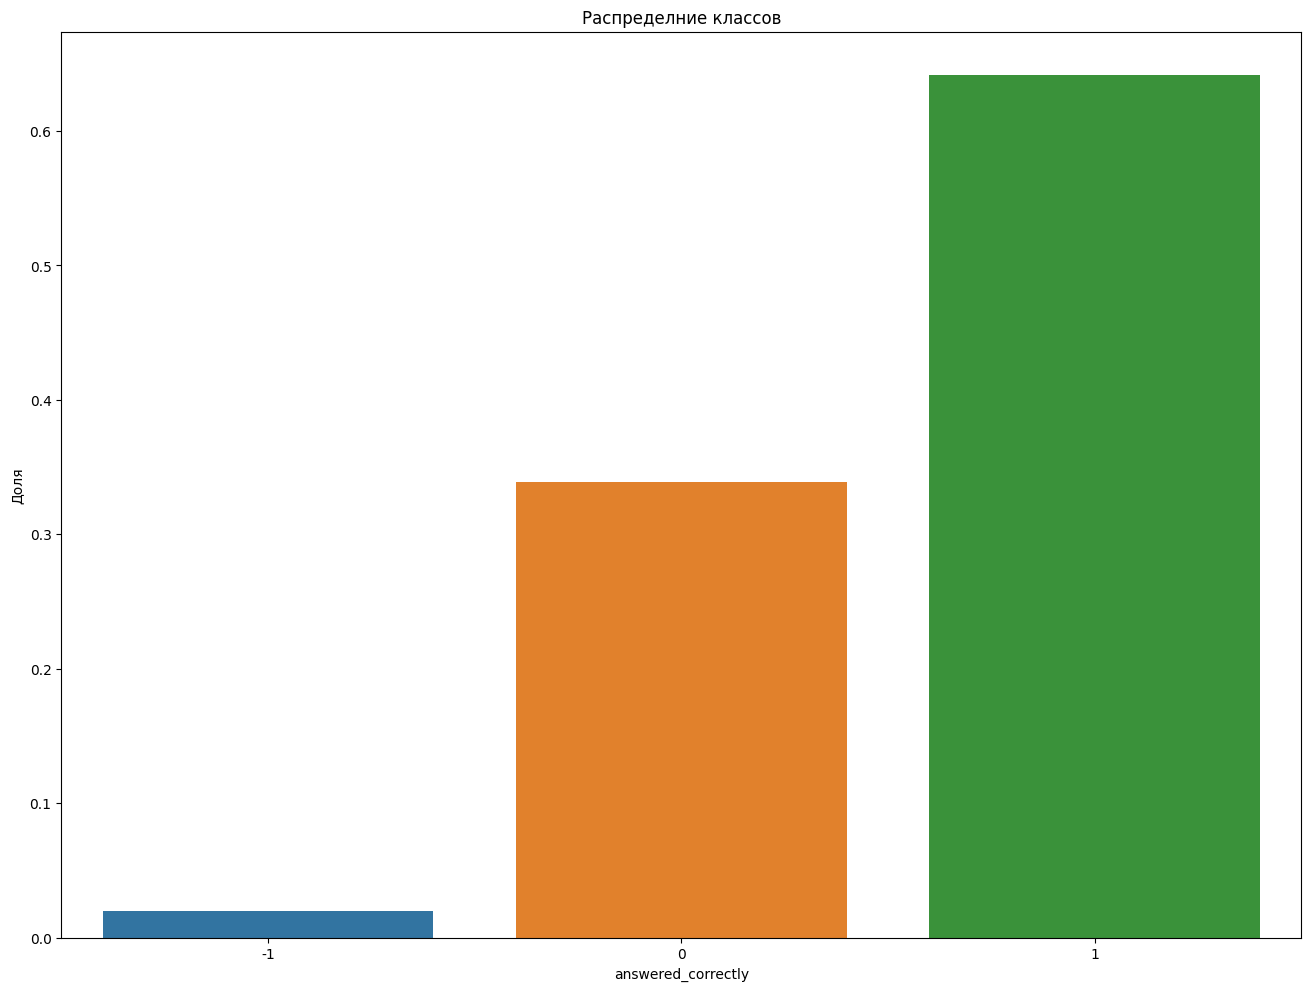

In [11]:
# у нас есть явный дисбаланса классов в данных
# правильных ответов в районе 60%  

plt.figure(figsize=(16, 12), dpi=100)

plot_data = df['answered_correctly'].value_counts(normalize=True)
plot_data = plot_data.reset_index()
sns.barplot(data=plot_data, x='index', y='answered_correctly')

plt.title('Распределние классов');
plt.xlabel('answered_correctly');
plt.ylabel('Доля');


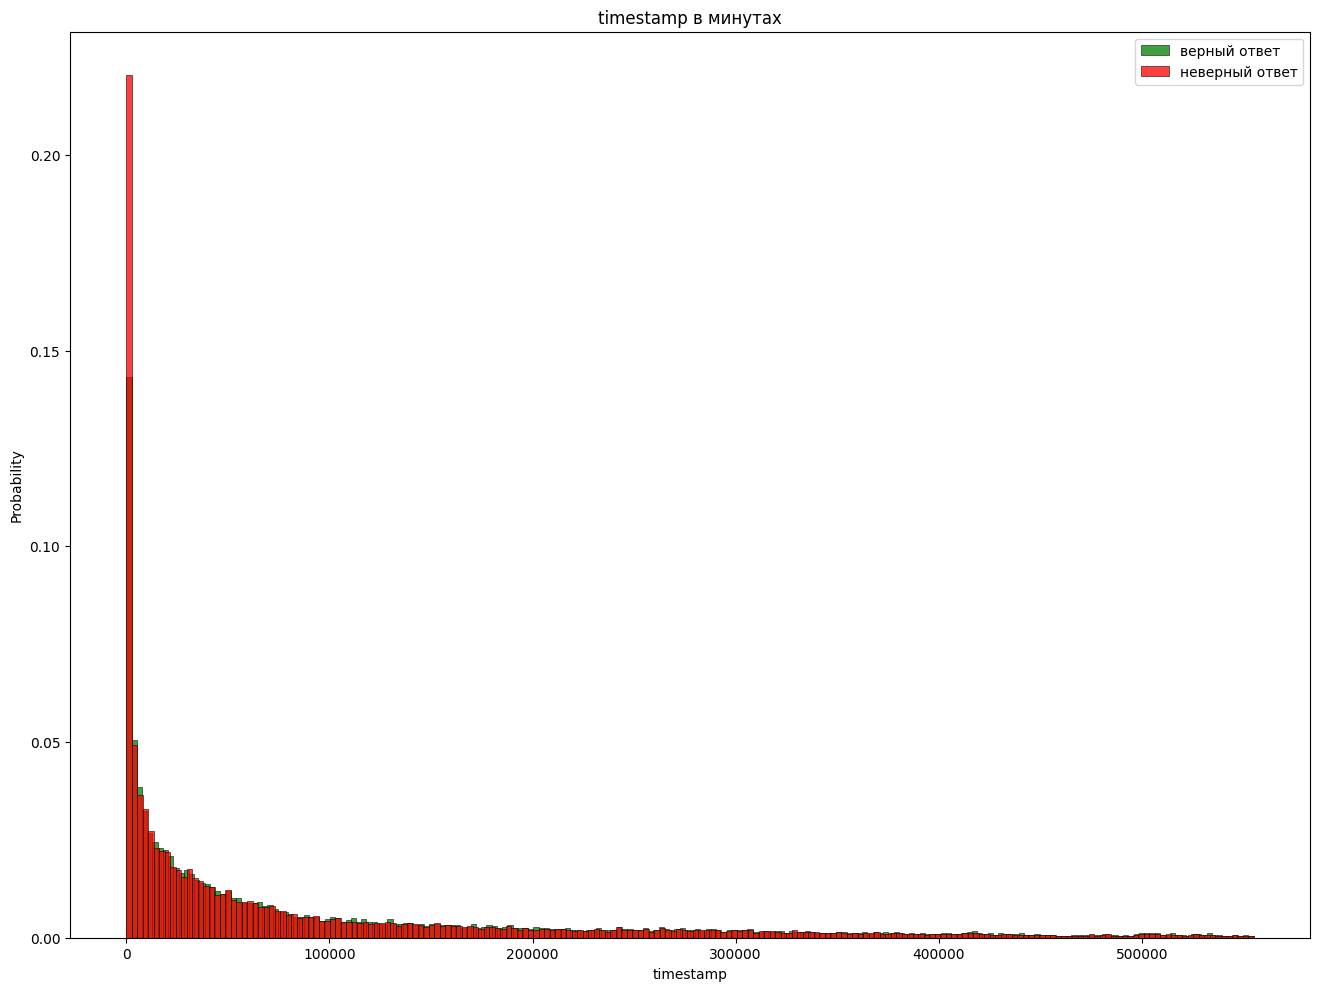

In [12]:
# изучим как распределены разные классы и признаки в данных

# для того чтобы не вестись на дисбаланс классов
# будем смотреть вероятности внутри классов
plt.figure(figsize=(16, 12), dpi=100)

# отрезаем хвост данных, чтобы на картинке можнол было хоть что-то разобрать
plot_data = df[df['timestamp'] < df['timestamp'].quantile(0.95)][['timestamp', 'answered_correctly']]

sns.histplot(
    data=plot_data[plot_data['answered_correctly'] == 1],
    x='timestamp',
    stat='probability',
    color='green',
    label='верный ответ',
);
sns.histplot(
    data=plot_data[plot_data['answered_correctly'] == 0],
    x='timestamp',
    stat='probability',
    color='red',
    label='неверный ответ',
);

plt.title('timestamp в минутах');
plt.legend();

# как видно из нормированных распределений
# распределение практически идентично
# за исключением 1-го бара - там видно
# что ошибки с высокой вероятностью
# сопровождаются быстрым ответом

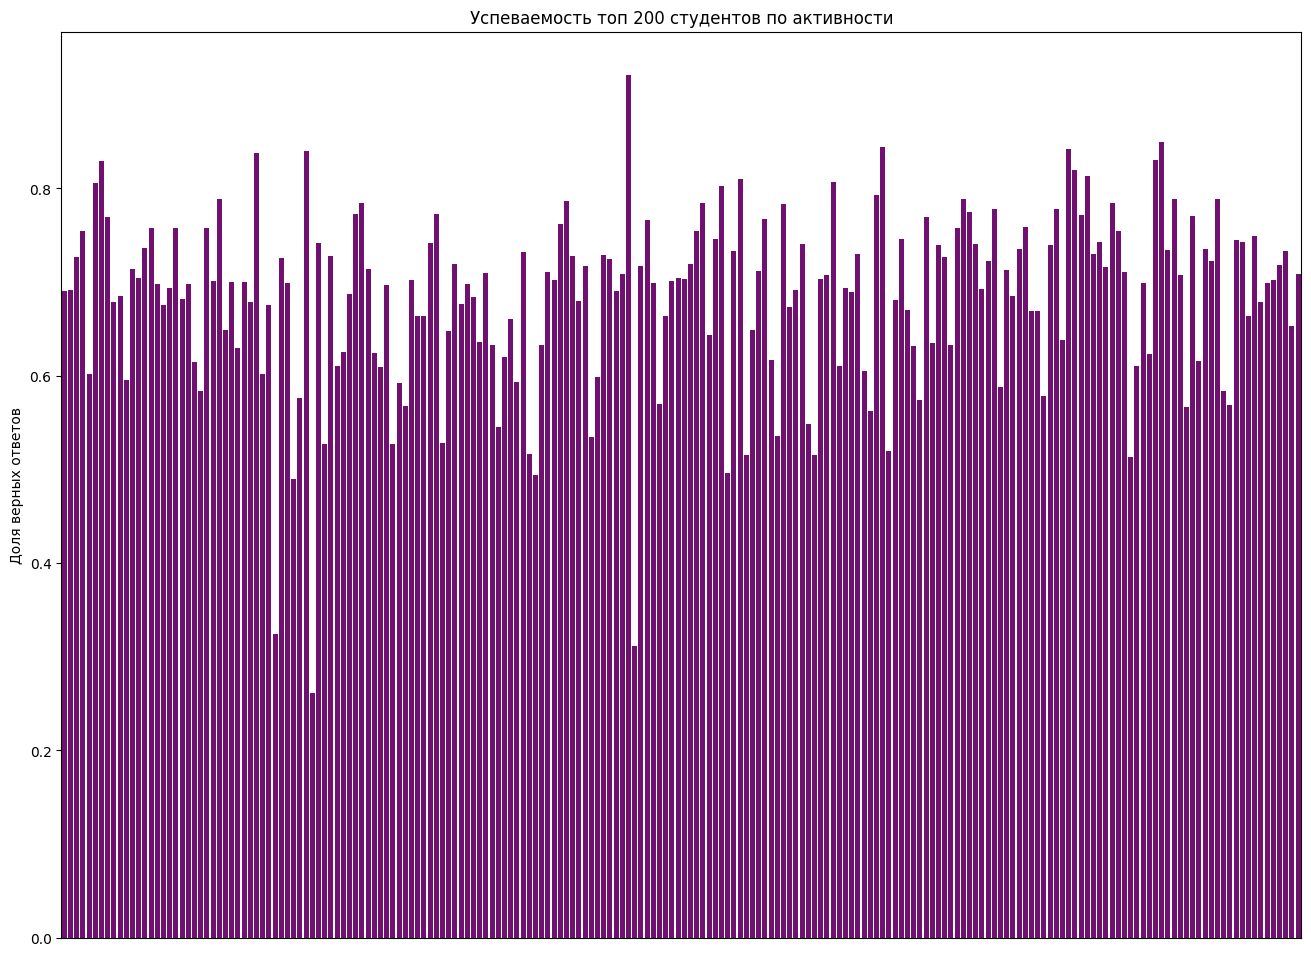

In [13]:

plt.figure(figsize=(16, 12), dpi=100)

# возьмем топ 200 студентов по взаимодействиям
users = df['user_id'].value_counts().head(200).index

plot_data = df[
    (df['user_id'].isin(users))
    &(df['answered_correctly'] != -1)
][['user_id', 'answered_correctly']]
ax = sns.barplot(
    data=plot_data,
    x='user_id',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('Успеваемость топ 200 студентов по активности');
plt.ylabel('Доля верных ответов');

# по графикам видно очевидное
# успеваемость индивидуально для каждого студента

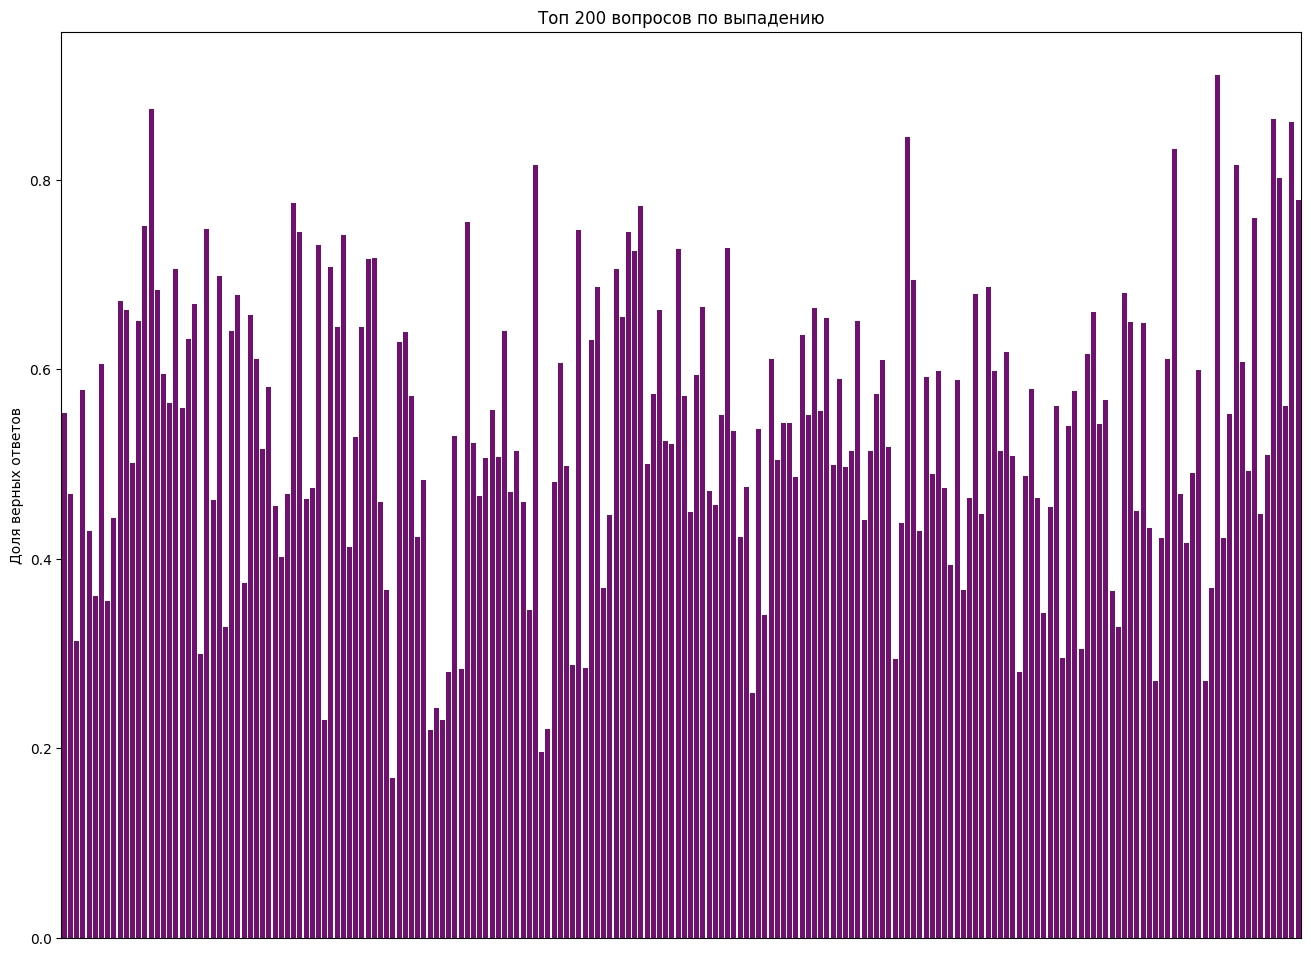

In [14]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['content_type_id'] == 0)][['content_id', 'answered_correctly']]
content = plot_data['content_id'].value_counts().head(200).index

plot_data = plot_data[plot_data['content_id'].isin(content)]

ax = sns.barplot(
    data=plot_data,
    x='content_id',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('Топ 200 вопросов по выпадению');
plt.ylabel('Доля верных ответов');

# так же очевидная вещь - есть простые воспросы на которые
# отвечают практчески все - есть не очень легкие вопросы

In [15]:
# content_type_id имеет множество значений только 0 и 1
# причем релевантные классы содержатся только при
# content_type_id == 0 - смысла анализировать не видно

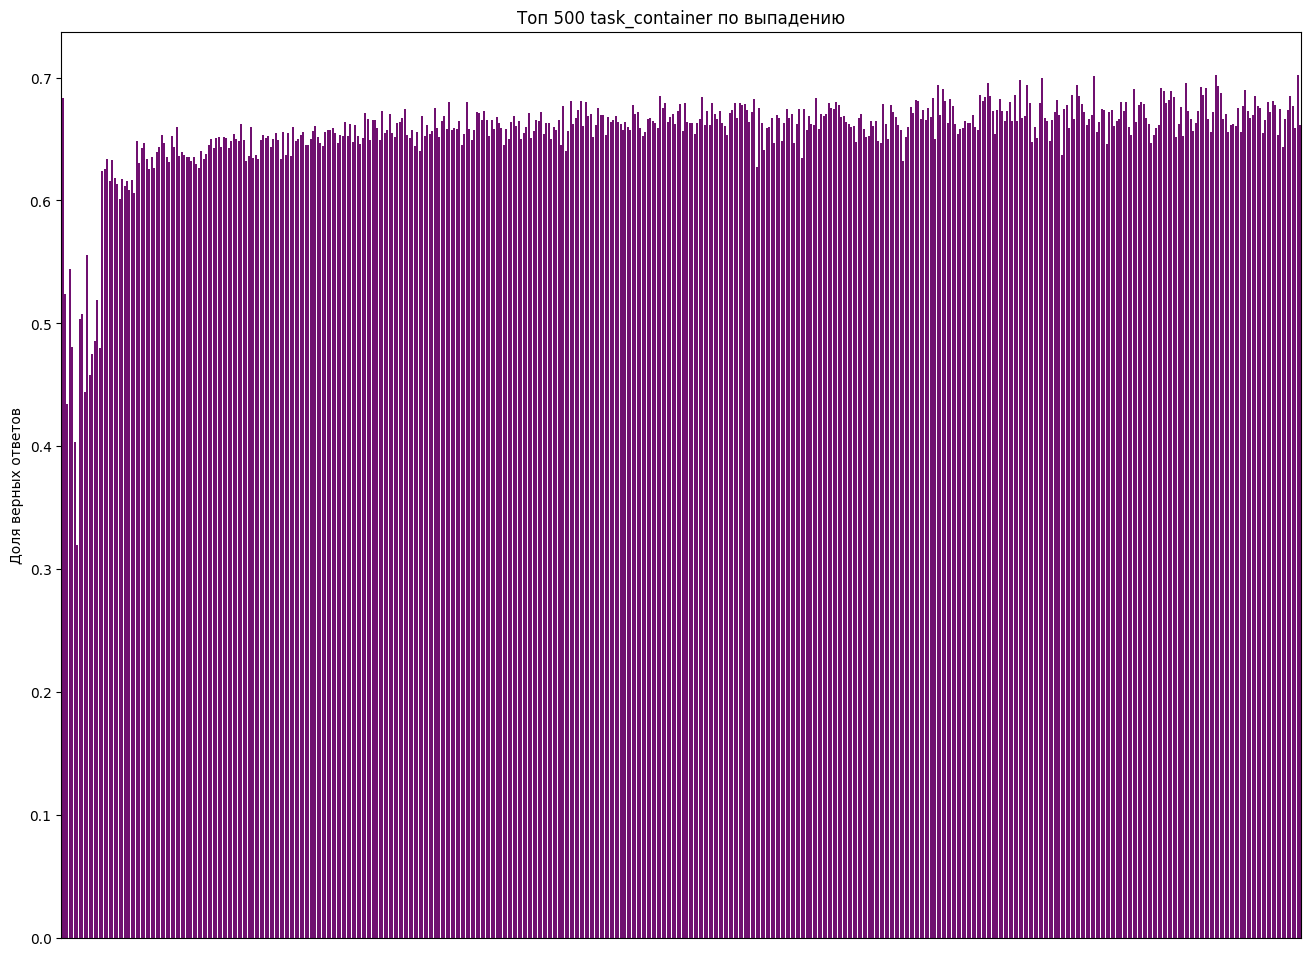

In [16]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['content_type_id'] == 0)][['task_container_id', 'answered_correctly']]
id = plot_data['task_container_id'].value_counts().head(500).index

plot_data = plot_data[plot_data['task_container_id'].isin(id)]

ax = sns.barplot(
    data=plot_data,
    x='task_container_id',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('Топ 500 task_container по выпадению');
plt.ylabel('Доля верных ответов');

# как видно task_container практически все одинаковые по доле верных ответов - за исключением самых топовых слева

In [17]:
# user_answer - напрямую связана с таргетом
# ее не следует анализировать тк ее будет тяжело использовать в ml

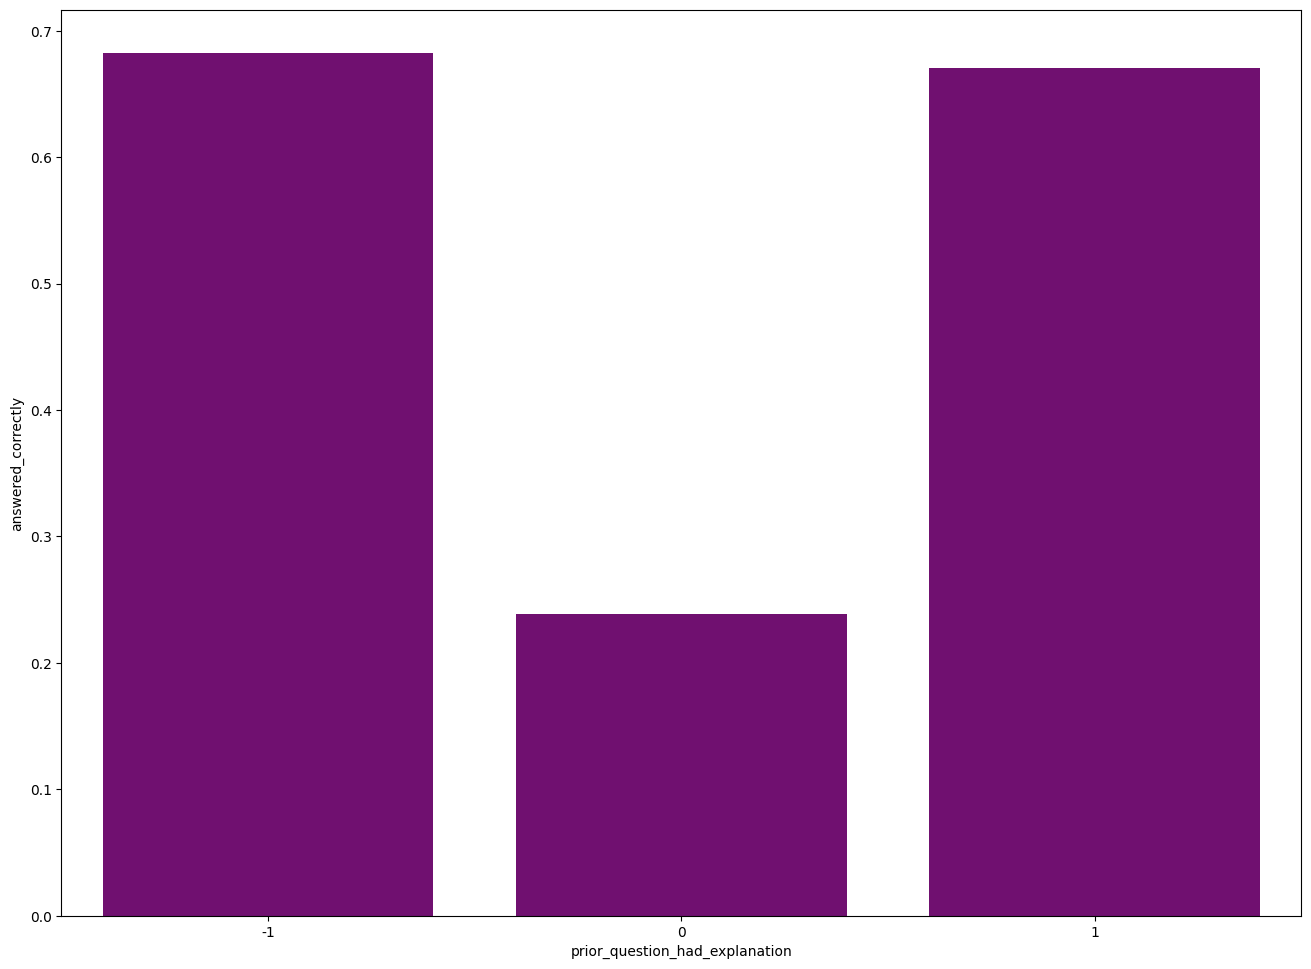

In [18]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[['prior_question_had_explanation', 'answered_correctly']]
ax = sns.barplot(
    data=plot_data,
    x='prior_question_had_explanation',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);

# тут высвечивается зависимость успеваемости в заивисимости от объяснения прошлого вопроса

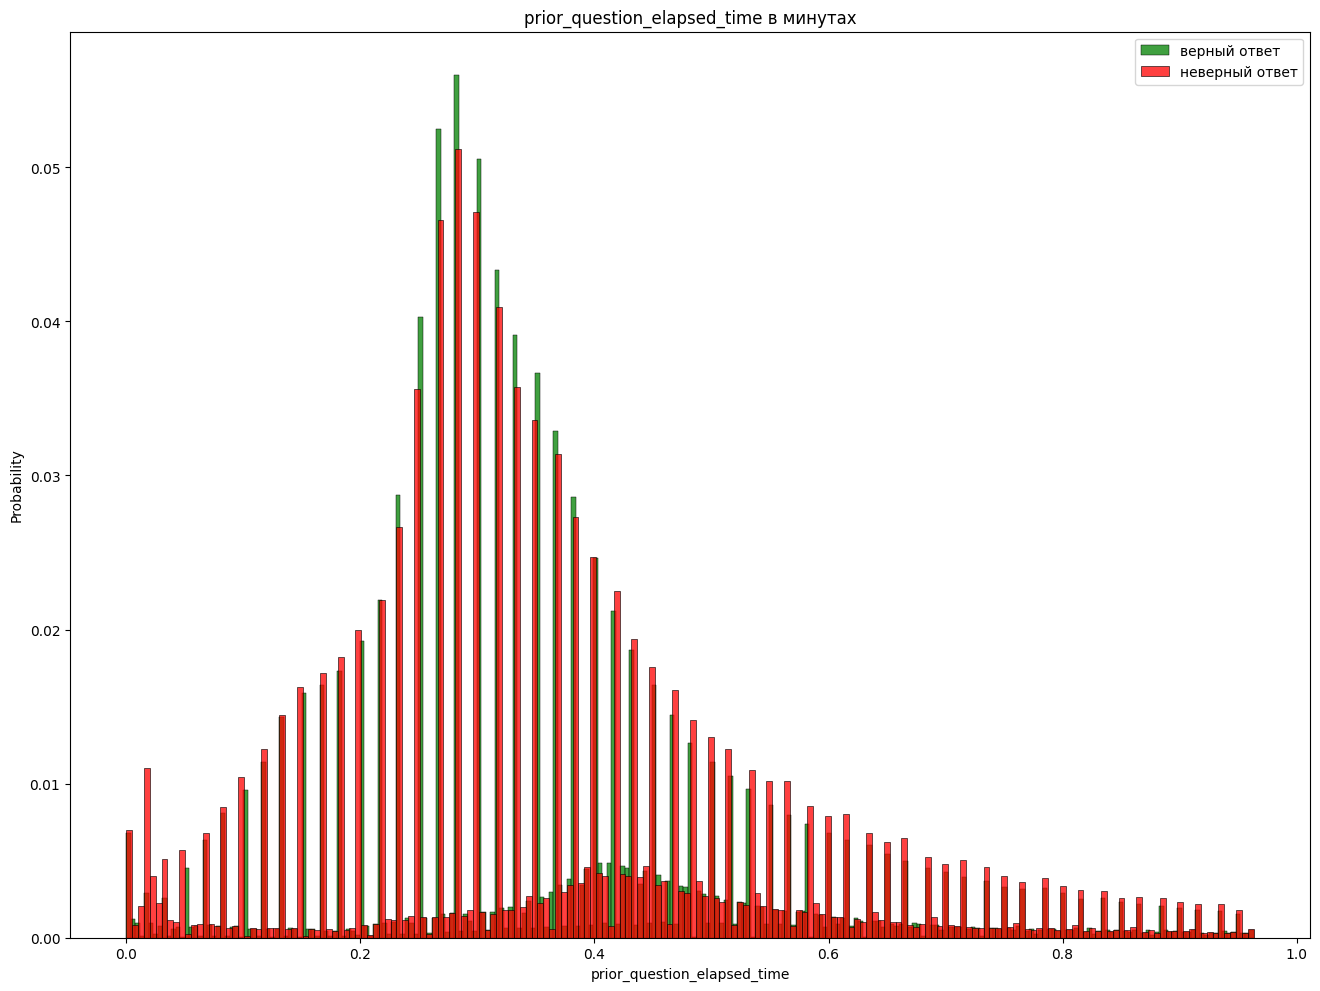

In [19]:
plt.figure(figsize=(16, 12), dpi=100)

# отрезаем хвост данных, чтобы на картинке можнол было хоть что-то разобрать
plot_data = df[df['prior_question_elapsed_time'] < df['prior_question_elapsed_time'].quantile(0.95)][['prior_question_elapsed_time', 'answered_correctly']]

plot_data['prior_question_elapsed_time'] /= 60 * 1000

sns.histplot(
    data=plot_data[plot_data['answered_correctly'] == 1],
    x='prior_question_elapsed_time',
    stat='probability',
    color='green',
    label='верный ответ',
);
sns.histplot(
    data=plot_data[plot_data['answered_correctly'] == 0],
    x='prior_question_elapsed_time',
    stat='probability',
    color='red',
    label='неверный ответ',
);

plt.title('prior_question_elapsed_time в минутах');
plt.legend();

# тут сложно рассмотреть какой то инсайд - поведение +- одинаковое

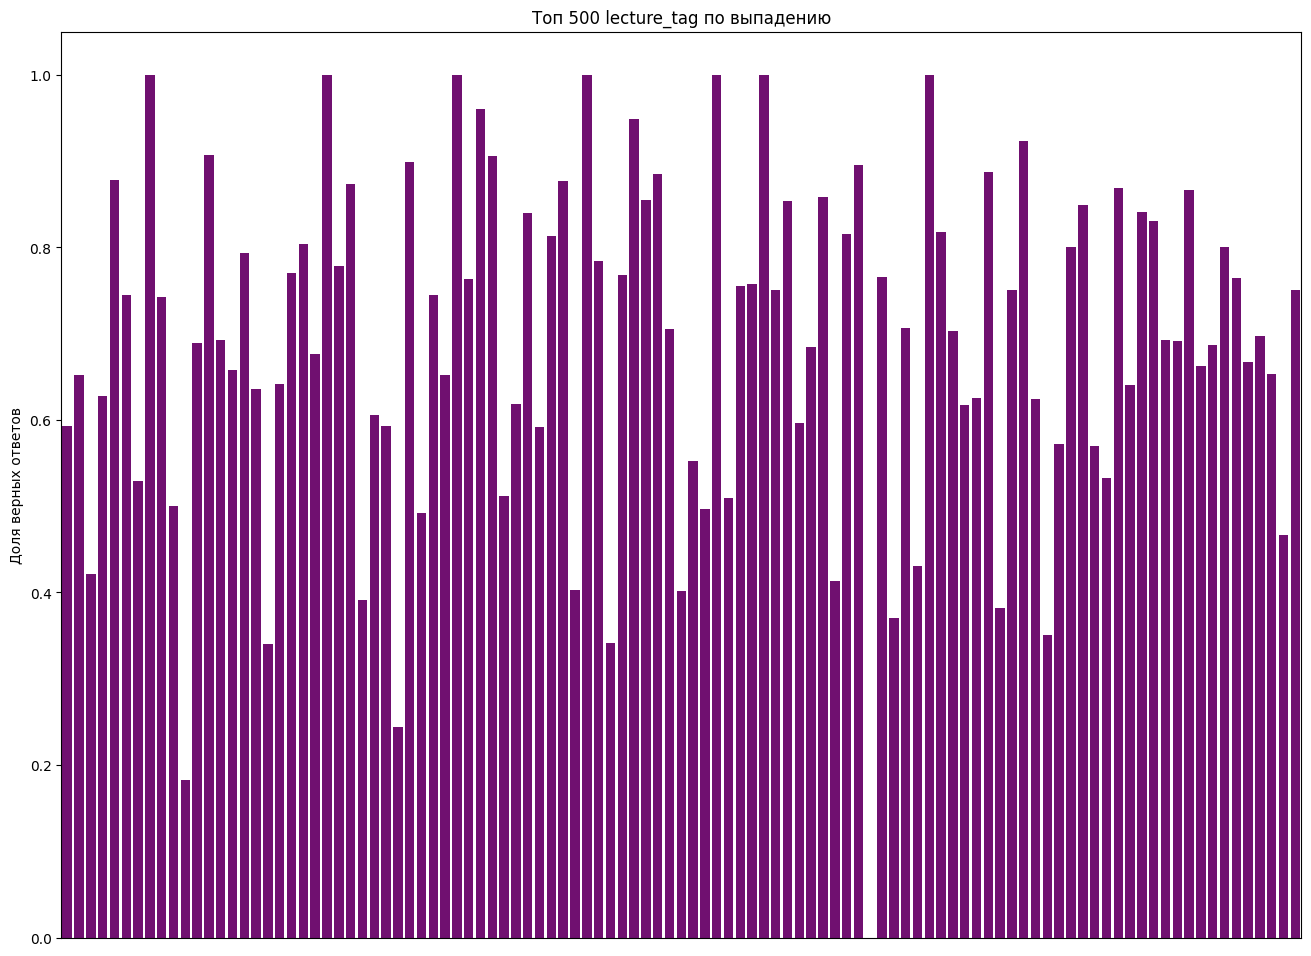

In [20]:
# изучим блоки с lectures.csv
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['lecture_tag'] != -1) & (df['answered_correctly'] != -1)][['lecture_tag', 'answered_correctly']]
lect = plot_data['lecture_tag'].value_counts().head(500).index

plot_data = plot_data[plot_data['lecture_tag'].isin(lect)]

ax = sns.barplot(
    data=plot_data,
    x='lecture_tag',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('Топ 500 lecture_tag по выпадению');
plt.ylabel('Доля верных ответов');

# прорисовывается сепарабельность по lecture_tag

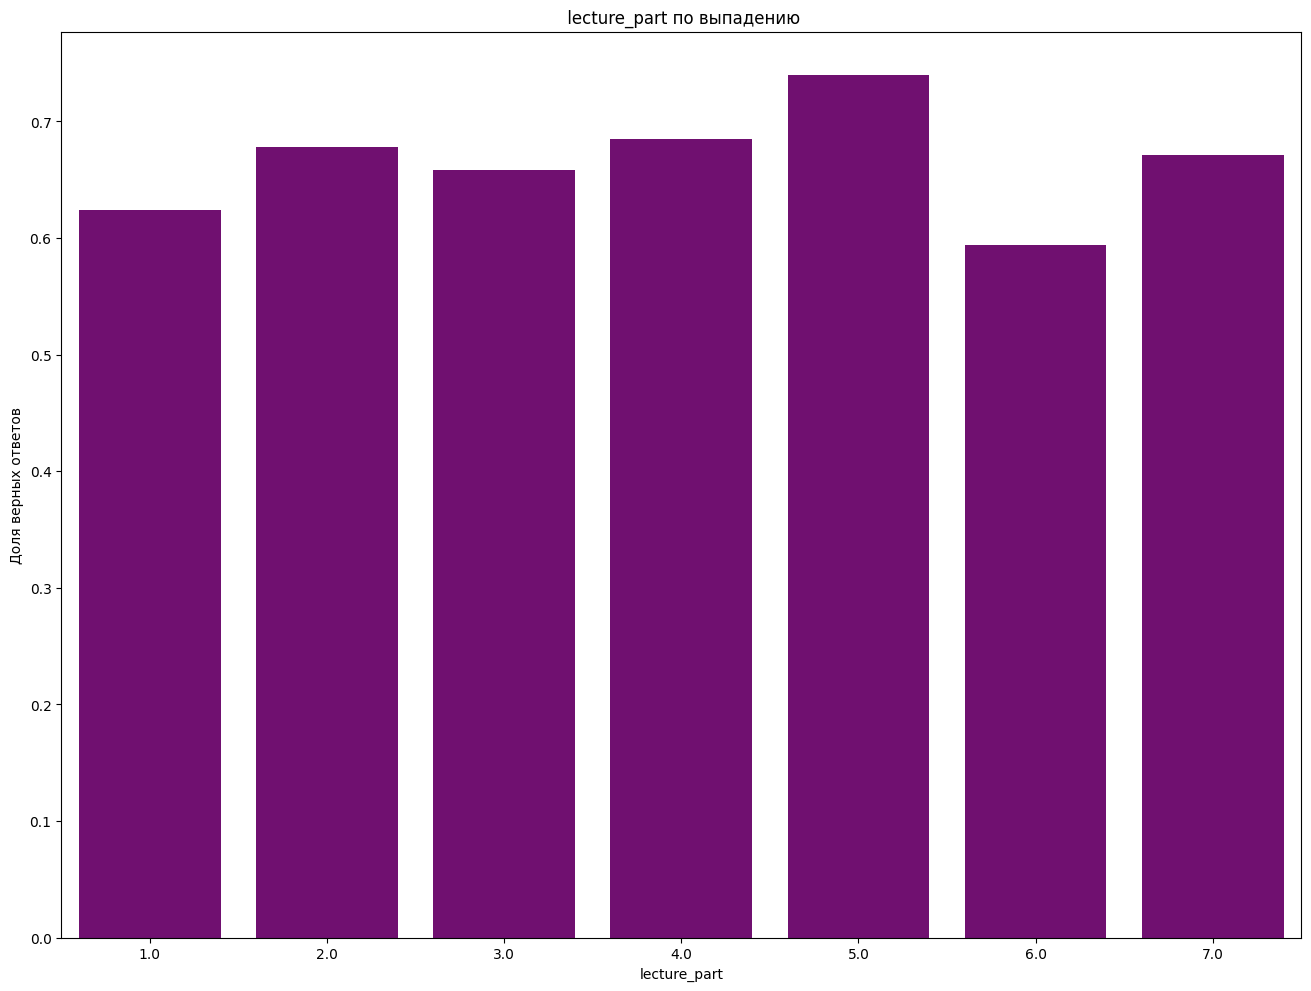

In [21]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['lecture_part'] != -1) & (df['answered_correctly'] != -1)][['lecture_part', 'answered_correctly']]

ax = sns.barplot(
    data=plot_data,
    x='lecture_part',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);

plt.title(' lecture_part по выпадению');
plt.ylabel('Доля верных ответов');

# не видно сепарабельности по частям лекции - видимо лекции сложные вкупе

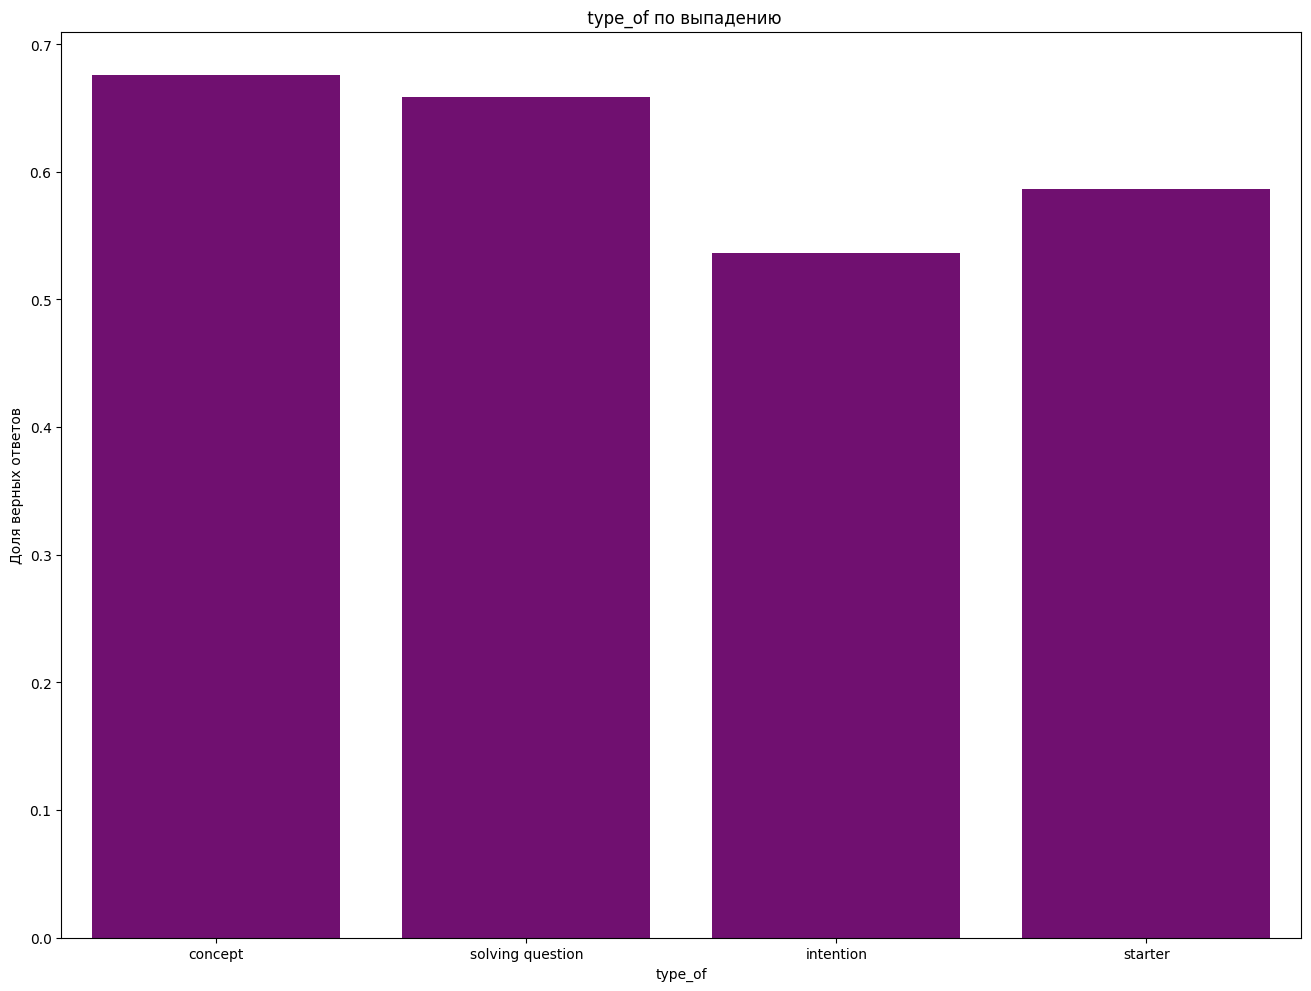

In [22]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['type_of'] != -1) & (df['answered_correctly'] != -1)][['type_of', 'answered_correctly']]

ax = sns.barplot(
    data=plot_data,
    x='type_of',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);

plt.title(' type_of по выпадению');
plt.ylabel('Доля верных ответов');

 # сепарабельности не наблюдается

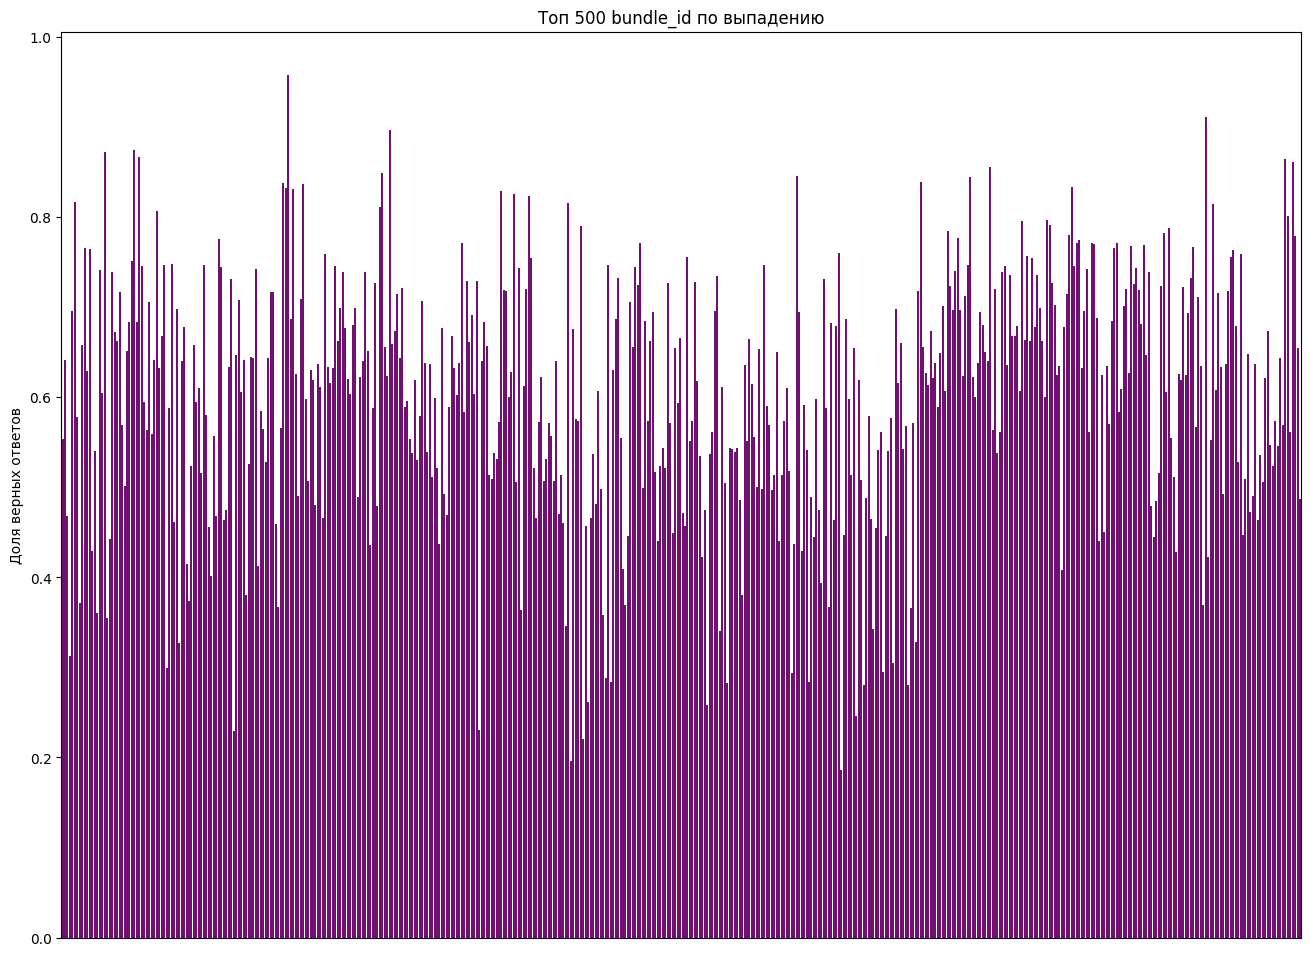

In [23]:
# изучим блоки с questions.csv

plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['bundle_id'] != -1) & (df['answered_correctly'] != -1)][['bundle_id', 'answered_correctly']]
id = plot_data['bundle_id'].value_counts().head(500).index

plot_data = plot_data[plot_data['bundle_id'].isin(id)]

ax = sns.barplot(
    data=plot_data, 
    x='bundle_id', 
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('Топ 500 bundle_id по выпадению');
plt.ylabel('Доля верных ответов');

# видно что есть сложные бандлы вопрос где низкий скор ответов и наоборот

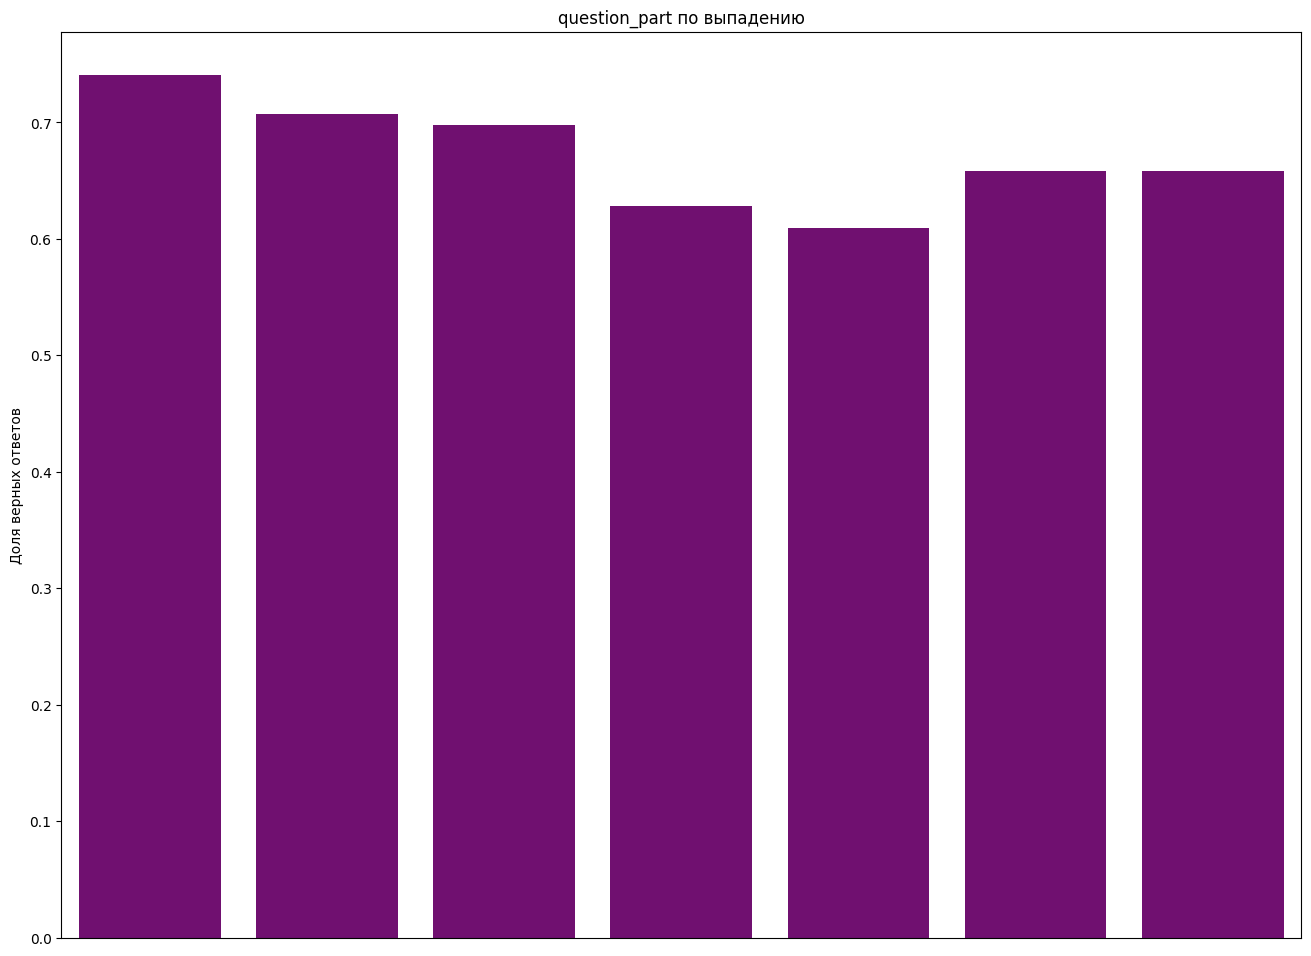

In [24]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['question_part'] != -1) & (df['answered_correctly'] != -1)][['question_part', 'answered_correctly']]

ax = sns.barplot(
    data=plot_data,
    x='question_part',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('question_part по выпадению');
plt.ylabel('Доля верных ответов');

# отсуствует разделение (практически) - видимо части перемешиваются

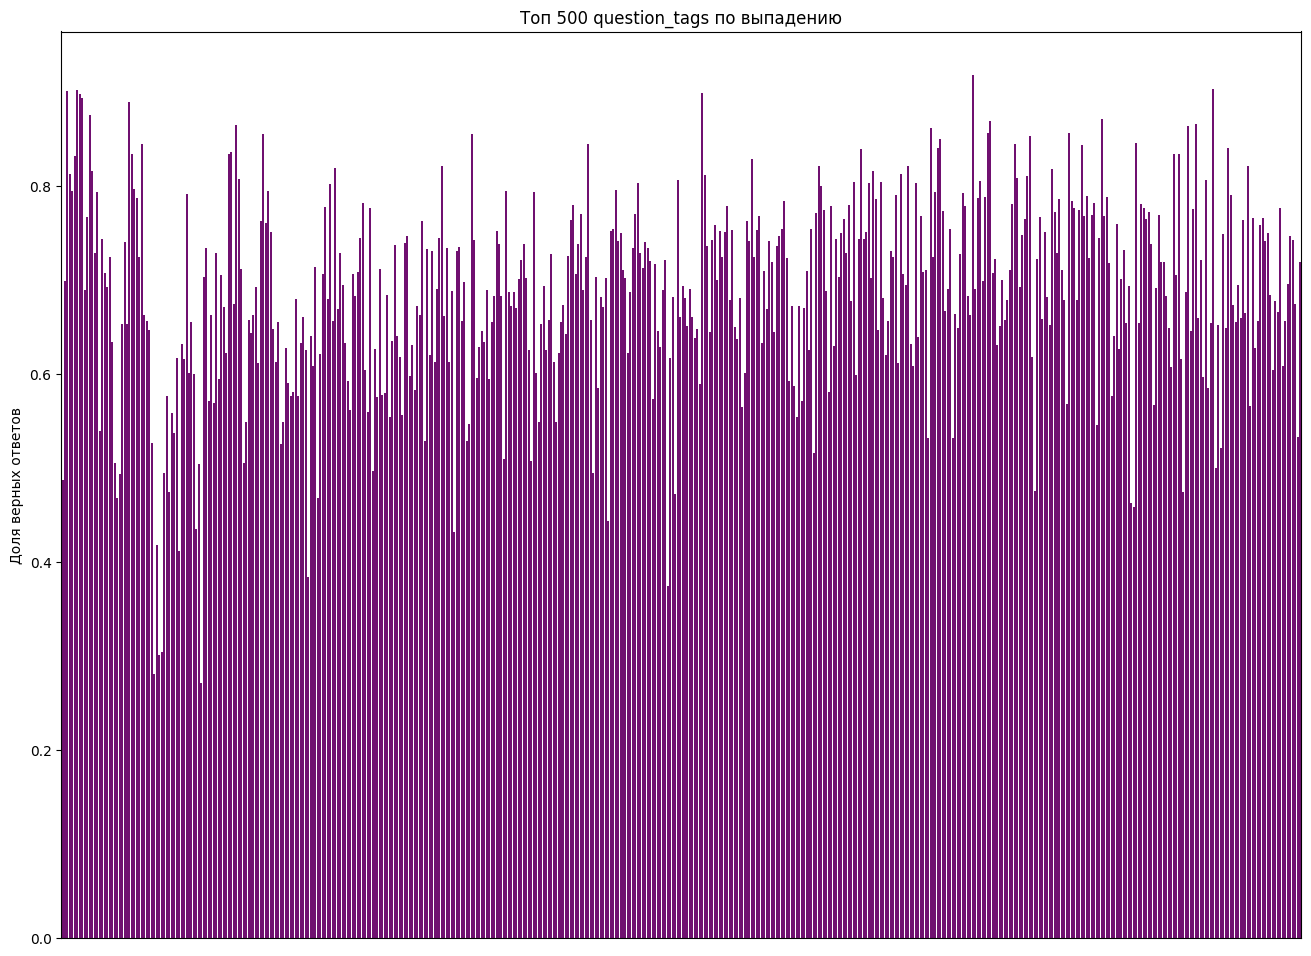

In [25]:
plt.figure(figsize=(16, 12), dpi=100)

plot_data = df[(df['question_tags'] != -1) & (df['answered_correctly'] != -1)][['question_tags', 'answered_correctly']]
lect = plot_data['question_tags'].value_counts().head(500).index

plot_data = plot_data[plot_data['question_tags'].isin(lect)]

ax = sns.barplot(
    data=plot_data,
    x='question_tags',
    y='answered_correctly',
    estimator=np.mean,
    color='purple',
    ci=None
);
ax.get_xaxis().set_visible(False);

plt.title('Топ 500 question_tags по выпадению');
plt.ylabel('Доля верных ответов');

# предполагая что question_tags характеризует какие то темы - можно говорить что есть легкие темы, есть сложные

### Итог:
1. Изучено распределние практически всех признаков
2. Выделены признаки, которые дают разделение для целевой переменной